# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy

## Data

Download data

In [3]:
home_dir = "./MDC_waveforms/"

In [4]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [5]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

In [6]:
len(H_data)

65536

In [7]:
H_peak = np.argmax(H_data)

In [8]:
start_time = H_data.times.value[H_peak]
t0 = H_data.times[H_peak]

(1126259461.9134278, 1126259462.2134278)

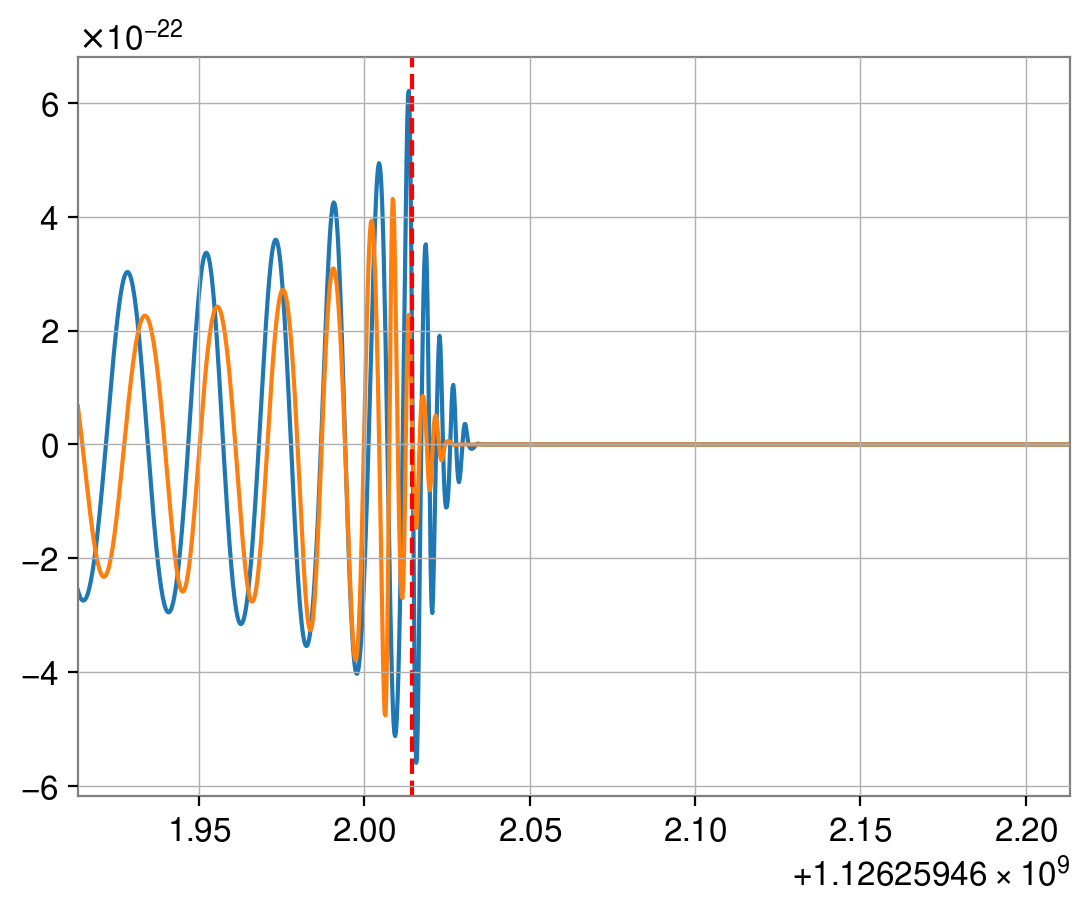

In [9]:
pl.plot(H_data.times, H_data.value)
pl.plot(L_data.times, L_data.value)
pl.axvline(start_time+1e-3, c = 'r', ls = '--')
pl.xlim(H_data.times.value[H_peak]-0.1, H_data.times.value[H_peak]+0.2)

## Noise

In [10]:
length = len(H_data.times)
noise = np.random.normal(0,1e-23,length)

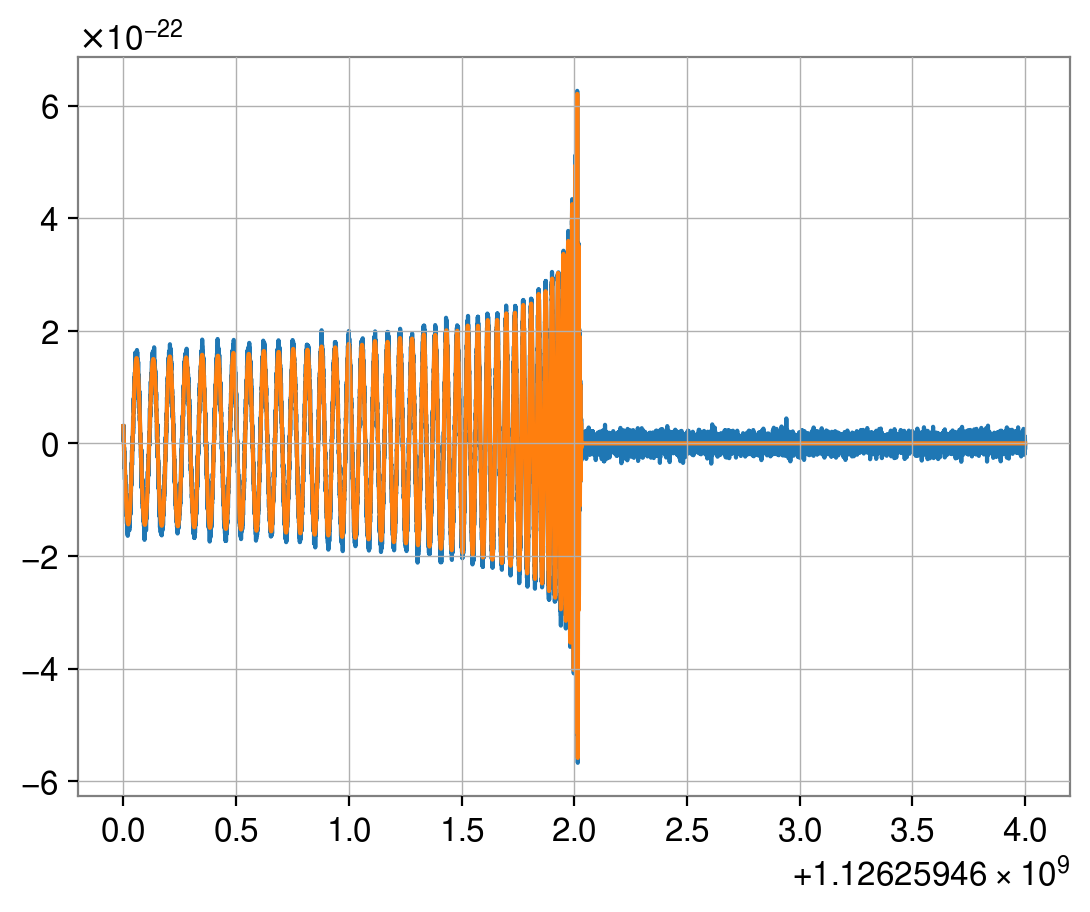

In [11]:
trim = int(3*len(H_data)/4)
pl.plot(H_data.times[trim:], H_data.value[trim:]+noise[trim:])
pl.plot(H_data.times[trim:], H_data.value[trim:])

In [12]:
H_waveform = qnm_filter.Data(H_data.value[trim:]+noise[trim:], index = H_data.times[trim:].value)
L_waveform = qnm_filter.Data(L_data.value[trim:]+noise[trim:], index = L_data.times[trim:].value)
noise_waveform = qnm_filter.Data(noise[trim:], index = L_data.times.value[trim:])

## Filter

In [13]:
fit = qnm_filter.Network(window_width=0.2, srate=4096, t_init = start_time+1e-3)

Load data

In [14]:
fit.original_data['H1'] = L_waveform
fit.detector_alignment()

In [15]:
fit.pure_noise = {}
fit.pure_noise['H1'] = noise_waveform
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
delta_mass = 0.4
delta_chi = 0.01
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [27]:
fit.first_index()
index_spacing = 10
num_iteration = 15
initial_offset = -50

In [28]:
fitnew=copy.deepcopy(fit)

In [29]:
t_array, saved_log_evidence = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = 9, 
                                                           verbosity=False, model_list = [(2, 2, 0)])

In [30]:
t_array_no_filter, saved_log_evidence_no_filter = qnm_filter.evidence_parallel(fitnew, index_spacing, num_iteration, 
                                                                               initial_offset, massspace, chispace, 
                                                                               num_cpu = 9, verbosity=False, 
                                                                               apply_filter=False, 
                                                                               model_list = [(2, 2, 0)])

In [31]:
saved_log_evidence /= np.log(10) # ln to lg
saved_log_evidence_no_filter /= np.log(10)

Text(0.5, 0, 't (ms)')

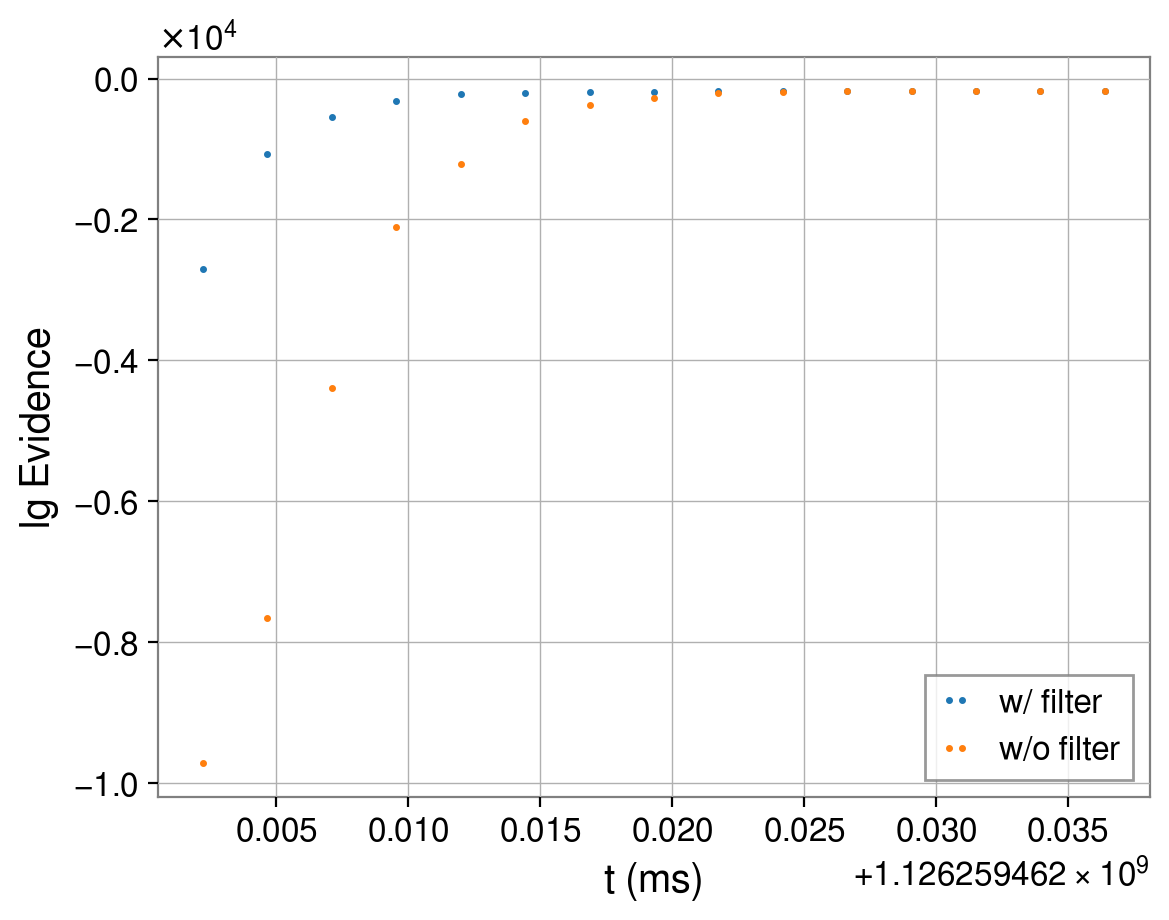

In [32]:
pl.plot(t_array, saved_log_evidence, 'o', ms=1.5, label='w/ filter')
pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')